## Loading Dataset

In [4]:
!pip install opendatasets --quiet

In [5]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  jaweriaasifkhan


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


100%|██████████| 1.03G/1.03G [00:00<00:00, 1.18GB/s]


In [6]:
# data is downloaded in dir asl-alphabet

import os

os.listdir('asl-alphabet')

['asl_alphabet_train', 'asl_alphabet_test']

In [7]:
# os.listdir('asl-alphabet/asl_alphabet_test/asl_alphabet_test')

# Importing Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import random_split

# Check GPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# Transforms (Preprocessing + Augmentation)


In [10]:
image_size = 224  # resize images to 128x128 for balance of speed+accuracy


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # keep size same as before
    transforms.RandomHorizontalFlip(),      # flip hands
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),  # simulate lighting & skin tones
    transforms.RandomRotation(15),          # simulate hand angle
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # simulate shifting
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Load Dataset

We’ll use ImageFolder since classes are in separate folders.

In [11]:
# Loading train and test dala

# loading train data
train_dir = "asl-alphabet/asl_alphabet_train/asl_alphabet_train"
full_train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# With a fixed seed, I (and others) can reproduce exactly the same results.
generator = torch.Generator().manual_seed(42) # fixed seed

# split train data into train, test and val
train_size = int(0.8 * len(full_train_data))
val_size = int(0.1 * len(full_train_data))
test_size  = len(full_train_data) - train_size - val_size

train_data, val_data, test_data = random_split(full_train_data, [train_size, val_size, test_size], generator=generator)



# DataLoader

In [12]:
# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model – Transfer Learning (ResNet18)

We’ll fine-tune a pretrained model:

In [13]:
model = models.resnet18(pretrained=True)

# Freeze only first two blocks
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False

# Unfreeze higher layers
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Replace final FC layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 29)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


# Setting Learning rate and Epochs
Choose hyperparameters such as learning rate and number of epochs to control model training speed and duration.

In [14]:
learning_rate = 0.001
epochs = 10
patience = 5

# Instantiate, loss and Optimizer

In [15]:
from torch.optim.lr_scheduler import StepLR


# Instantiate the model and send it to cuda
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
# optimizer = optim.Adam(model.fc.parameters(), lr = learning_rate)  # training only final layer (fc layer)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # reduce LR every 3 epochs


# Early Stopping

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        patience: how many epochs to wait after last improvement
        min_delta: minimum change in validation loss to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Training Loop

In [17]:
# training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs = epochs, patience=patience):
  history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

  # Create EarlyStopping instance
  early_stopping = EarlyStopping(patience=patience, min_delta=0.0)


  for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0,0,0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      # grad zero
      optimizer.zero_grad()     # clears old gradients

      # Forwad Pass
      outputs = model(images)

      # Loss calculation
      loss = criterion(outputs, labels)

      # back propagation
      loss.backward()      #  compute new gradients

      # update parameters
      optimizer.step()     # update weights

      running_loss += loss.item()
      _, predicted = outputs.max(1)  # _ = we ignore the actual max values (probabilities).
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

      val_loss /= len(val_loader)
      val_acc = 100. * correct / total

      history["train_loss"].append(train_loss)
      history["val_loss"].append(val_loss)
      history["train_acc"].append(train_acc)
      history["val_acc"].append(val_acc)

      # SCHEDULER HERE
      scheduler.step()

      print(f"Epoch {epoch + 1}/{epochs} |Train Lose:{train_loss} | Train Acc: {train_acc:.2f}% |Val Lose:{val_loss} | Val Acc: {val_acc:.2f}%")


        # ---------- Early Stopping Check ----------
      early_stopping(val_loss)
      if early_stopping.early_stop:
         print("⏹️ Early stopping triggered!")
         break

  return history



In [18]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs = epochs, patience = patience)

Epoch 1/10 |Train Lose:0.17804136394838946 | Train Acc: 96.56% |Val Lose:0.018814861618653488 | Val Acc: 99.52%
Epoch 2/10 |Train Lose:0.013509583004687395 | Train Acc: 99.68% |Val Lose:0.004922387377412045 | Val Acc: 99.90%
Epoch 3/10 |Train Lose:0.010129990366401805 | Train Acc: 99.74% |Val Lose:0.0045311648387081835 | Val Acc: 99.90%
Epoch 4/10 |Train Lose:0.002578185346411534 | Train Acc: 99.96% |Val Lose:0.0015488812259718543 | Val Acc: 99.98%
Epoch 5/10 |Train Lose:0.0016296140016519905 | Train Acc: 99.98% |Val Lose:0.0005781435912628213 | Val Acc: 100.00%
Epoch 6/10 |Train Lose:0.0010965029111556599 | Train Acc: 99.99% |Val Lose:0.0006369751712661716 | Val Acc: 99.99%
Epoch 7/10 |Train Lose:0.0008370785629281005 | Train Acc: 99.99% |Val Lose:0.0003677576477296979 | Val Acc: 100.00%
Epoch 8/10 |Train Lose:0.0006654514009650323 | Train Acc: 100.00% |Val Lose:0.00032495445975655457 | Val Acc: 100.00%
Epoch 9/10 |Train Lose:0.0007695182702839113 | Train Acc: 99.99% |Val Lose:0.00044

# Evaluation on test data

In [19]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

test_acc = evaluate(model, test_loader)
print("Test Accuracy:", test_acc, "%")


Test Accuracy: 99.98850574712644 %


# Plot Performance

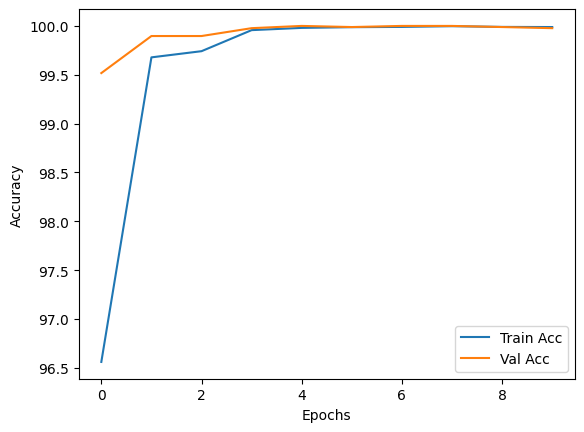

In [20]:
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Testing on unseen data 

In [22]:
import torch
import torch.nn.functional as F
from PIL import Image

def predict_single_image(model, img_path, transform, device, classes):
    """
    Predict class for a single image
    """
    model.eval()
    img = Image.open(img_path).convert('RGB')   # load image
    img_tensor = transform(img).unsqueeze(0).to(device)  # apply transforms + batch dimension
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)      # convert to probabilities
        conf, predicted = torch.max(probs, 1)  # confidence + class index
    
    return classes[predicted.item()], conf.item()


In [23]:
# Get classes from training dataset
from torchvision import datasets
train_dataset = datasets.ImageFolder("asl-alphabet/asl_alphabet_train/asl_alphabet_train", transform=None)
classes = train_dataset.classes   # same order as training

# Test with a single image
img_path = "asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg"

pred_class, confidence = predict_single_image(model, img_path, val_transforms, device, classes)

print(f"Predicted: {pred_class}, Confidence: {confidence:.4f}")


Predicted: A, Confidence: 0.9999


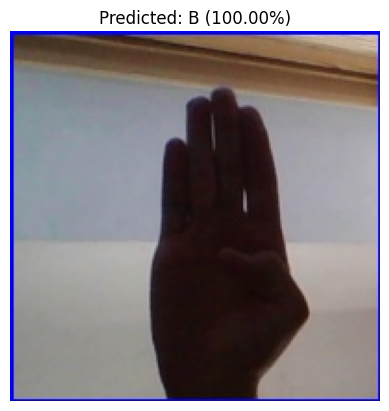

In [24]:
import matplotlib.pyplot as plt

def show_prediction(img_path, model, transform, device, classes):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        conf, predicted = torch.max(probs, 1)
    
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {classes[predicted.item()]} ({conf.item()*100:.2f}%)")
    plt.show()

# Example
show_prediction("asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg", model, val_transforms, device, classes)


# Saving model Weights and Classes

In [25]:
train_dataset.classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [26]:
import torch
import json
import os

save_dir = "asl_model_files"
os.makedirs(save_dir, exist_ok=True)

# 1. Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, "asl_model.pth"))

# 2. Save class labels (very important for correct predictions)
with open(os.path.join(save_dir, "asl_classes.json"), "w") as f:
    json.dump(train_dataset.classes, f)


In [27]:
import shutil

shutil.make_archive("asl_model_files", 'zip', "asl_model_files")


'/kaggle/working/asl_model_files.zip'

## Downloading files in our Computer

In [29]:
from IPython.display import FileLink
# 2. Create a download link
FileLink("asl_model_files.zip")

/kaggle/working/asl_model_files.zip

# Checking saved files in directory

In [30]:
import os
os.listdir("/kaggle/working")


['.virtual_documents',
 'asl-alphabet',
 'asl_model_files.zip',
 'asl_model_files']